In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from math import log
import lightgbm as lgb
import shap
import os
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from geopy import distance

pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

path_data = r'C:\Users\stenner\Documents\GitHub\Personal-Project\Home-Scraper\data\data'
data = pd.read_pickle(os.path.join(path_data, 'data_final.pkl'))

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    
def free_space(del_list):
    for name in del_list:
        if not name.startswith('_'):
            del globals()[name]
    gc.collect()
    
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col


def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df


In [2]:
data = data[~data.Prezzo.isnull()]
data = data[data.Prezzo>30000].reset_index(drop = True)

milano_coordinates = (9.191383, 45.464211)

In [3]:
dist_vec = []
for _, row in data.iterrows():
    
    coord_home = tuple(row[['LONG_WGS84', 'LAT_WGS84']])
    dist_vec += [distance.distance(coord_home, milano_coordinates).kilometers]

In [4]:
data['distance_duomo'] = dist_vec

In [5]:
params = {
                    'objective': 'regression',
                    'boosting_type':'gbdt',
                    'metric':'rmse',
                    'learning_rate':.05,
                    'max_depth': -1,
                    'num_leaves': 2**8,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.8,
                    'subsample':0.8,
                    'early_stopping_rounds': 500, 
                    'importance_type':'gain',
                    'n_jobs': -1
}


In [6]:
column_to_use = [
                    'Sconto', 'Stanze', 'Metri', 'Bagni', 'Garantito', 'proprieta', 
                    'stato', 'classe_energetica', 'Piano','piano', 'ascensore', 'Tipologia', 'Anno_Costruzione',
                    'asta', 'QUARTIERE', 'MUNICIPIO',
                    'NIL', 'LONG_WGS84', 'LAT_WGS84', 'esselunga_distanza', 'carrefour_distanza', 'conad_distanza',
                    'coop_distanza', 'lidl_distanza', 'store_radius_0.25_km', 'store_radius_0.5_km',
                    'store_radius_1_km', 'distanza_minima_supermercato',
                    'supermercato_vicino', 'nome', 'linee', 'linee1', 'linee2',
                    'distanza_metro', 'area_parco', 'distanza_parco',
                    'Scuola dell\'infanzia_distanza', 'Scuola primaria_distanza',
                    'Scuola secondaria di primo grado_distanza',
                    'Scuola secondaria di secondo grado_distanza',
                    'violenza-sessuale_distanza_1k', 'rapine_distanza_1k',
                    'furti_distanza_1k', 'omicidi_distanza_1k', 'droga_distanza_1k',
                    'campi-nomadi_distanza_1k', 'reati_all_distanza_1k', 'distance_duomo'
                ]

categorical = ['Stanze', 'Bagni', 'Garantito', 'proprieta', 'stato','classe_energetica', 'Piano','piano',
               'ascensore', 'Tipologia', 'asta', 'QUARTIERE', 'MUNICIPIO',
              'NIL', 'supermercato_vicino', 'nome', 'linee', 'linee1', 'linee2']

In [7]:
for col in categorical:
    count_rows = data.groupby('NIL')['stato'].size()
    to_del = count_rows[count_rows < 30].index
    data = data[~data[col].isin(to_del)]
    


In [8]:
target = np.log1p(data['Prezzo']) 
train = data[column_to_use]

In [9]:
dictionary_encoder = {}
for cat in categorical:
    le = LabelEncoder()
        
    train[cat] = le.fit_transform(train[cat].astype(str)).astype(np.int16)
    dictionary_encoder = {cat: le}

In [10]:
to_erase_fow_now = ['Anno_Costruzione']
categorical = [x for x in categorical if x not in to_erase_fow_now]

train = train.drop(to_erase_fow_now, axis = 1)

In [11]:
strat = train['NIL'].astype(str)
le = LabelEncoder()
strat = le.fit_transform(strat).astype(np.int16)

In [12]:
#change all data type and after downcast

for col in train.columns:
    train[col] = train[col].astype(float)
    
train = reduce_mem_usage_sd(train)


Mem. usage decreased from  2.80 Mb to  0.93 Mb (66.7% reduction)


In [13]:
score = 0
n_fold = 5
model5 = []

folds = StratifiedKFold(n_splits=n_fold, shuffle = True, random_state = 0)

pred = np.zeros(train.shape[0])

gc.collect()
for fold_ , (trn_idx, val_idx) in tqdm(enumerate(folds.split(train,strat))):
        gc.collect()
        train_x, train_y = train.iloc[trn_idx,:], target.iloc[trn_idx]
        valid_x, valid_y = train.iloc[val_idx,:], target.iloc[val_idx]
        
        model = lgb.train(params, lgb.Dataset(train_x, label = train_y, categorical_feature = categorical), 
                          1000000, valid_sets = lgb.Dataset(valid_x, label = valid_y, categorical_feature = categorical),
                          valid_names = 'validation', verbose_eval = 500)
        gc.collect()
        
        pred[val_idx] = model.predict(valid_x)
        
        score_fold = model.best_score['validation']['rmse']
        score += score_fold/n_fold 
        model5.append(model)

        print('Fold: {}; RMSE: {:.3f}\n'.format(fold_, score_fold))
        
print('RLMSE : {}'.format(score))



Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


Training until validation scores don't improve for 500 rounds
[500]	validation's rmse: 0.124247
[1000]	validation's rmse: 0.123986
[1500]	validation's rmse: 0.123888
[2000]	validation's rmse: 0.123845
[2500]	validation's rmse: 0.123828
Early stopping, best iteration is:
[2403]	validation's rmse: 0.123825
Fold: 0; RMSE: 0.124

Training until validation scores don't improve for 500 rounds
[500]	validation's rmse: 0.124578
[1000]	validation's rmse: 0.124433
Early stopping, best iteration is:
[917]	validation's rmse: 0.124424
Fold: 1; RMSE: 0.124

Training until validation scores don't improve for 500 rounds
[500]	validation's rmse: 0.145147
[1000]	validation's rmse: 0.144707
[1500]	validation's rmse: 0.144673
[2000]	validation's rmse: 0.144656
[2500]	validation's rmse: 0.144667
Early stopping, best iteration is:
[2027]	validation's rmse: 0.144652
Fold: 2; RMSE: 0.145

Training until validation scores don't improve for 500 rounds
[500]	validation's rmse: 0.144334
[1000]	validation's rmse: 

In [15]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns


for fold_, mod in tqdm(enumerate(model5)):
    feature_importances['fold_{}'.format(fold_ + 1)] = mod.feature_importance(importance_type='gain')


In [16]:
best_ = (np.expm1(pred) - np.expm1(target)).argsort()[::-1].values

In [17]:
result = data
result['Pred'] = np.expm1(pred).astype(int)

result['Diff'] = result['Pred'] - result['Prezzo']
ordered_ = result.iloc[best_, :].reset_index(drop = True)


In [33]:
data.isna().mean()

Prezzo                                         0.000000
Prezzo_Vecchio                                 0.979047
Sconto                                         0.979047
Stanze                                         0.053562
Metri                                          0.000000
Bagni                                          0.056705
Piano                                          0.062991
Garantito                                      0.463855
Posizione                                      0.000000
Url                                            0.000000
Immagine                                       0.897852
proprieta                                      0.000000
stato                                          0.000000
classe_energetica                              0.000000
piano                                          0.000000
ascensore                                      0.000000
Tipologia                                      1.000000
Anno_Costruzione                               1

In [29]:
from datetime import date
date.today()

datetime.date(2020, 10, 10)

In [21]:
mask = (ordered_.Prezzo < ordered_.Pred) & (ordered_.Prezzo<360000)
mask = mask & ([x not in ['Piano Rialzato', 'Seminterrato'] for x in ordered_.Piano]) 
mask = mask & (ordered_.Metri > 70)# & (ordered_.asta != 'asta')
mask = mask & (ordered_.distance_duomo < 6)
# mask = mask & (ordered_.QUARTIERE == 'BICOCCA - GRECO')

ordered_.loc[mask, ['Prezzo', 'Diff', 'Url', 'Piano', 'Metri', 'distance_duomo']]#.sort_values('distance_duomo')

,Prezzo,Diff,Url,Piano,Metri,distance_duomo
17,280500.0,348973.0,https://www.immobiliare.it/annunci/77428188/,NaN,180.0,5.338570
20,280000.0,323371.0,https://www.immobiliare.it/annunci/77556674/,5,100.0,1.196128
46,325000.0,229771.0,https://www.immobiliare.it/annunci/82699885/,1,80.0,5.392496
58,195000.0,214635.0,https://www.immobiliare.it/annunci/78384519/,Terra,100.0,3.314068
105,195000.0,172165.0,https://www.immobiliare.it/annunci/81761946/,Terra,75.0,4.438799
114,350000.0,165751.0,https://www.immobiliare.it/annunci/82996967/,2,120.0,5.955890
145,159000.0,146592.0,https://www.immobiliare.it/annunci/72560988/,Ultimo,102.0,4.915859
151,330000.0,141720.0,https://www.immobiliare.it/annunci/81304201/,1,92.0,3.038033
152,270000.0,141560.0,https://www.immobiliare.it/annunci/82557917/,4,116.0,4.960742
153,349000.0,141444.0,https://www.immobiliare.it/annunci/82721827/,1,90.0,4.071260


In [28]:
(np.expm1(pred) - np.expm1(target))[7777]

40122.85441492649

In [8]:
pos = (data.Prezzo<300000) & ([x not in ['Seminterrato', 'Piano Rialzato', 'Terra'] for x in data.Piano]) & (data.Metri > 50)

# shap_matrix_1 = shap_matrix[pos,:]
# shap5_1 = np.array(shap5)[pos].tolist()
data_1 = data.loc[pos].reset_index(drop = True)
# pred_1 = np.expm1(pred[pos])
target_1 = np.expm1(target[pos].reset_index(drop = True))
train_1 = train.loc[pos].reset_index(drop = True)

In [9]:
shap.initjs()
def shapper(index):
    display(shap.force_plot(np.expm1(shap5_1[index].expected_value), np.expm1(shap_matrix_1[index,:]), train_1.loc[index,:]))
shapper(872)

NameError: name 'shap5_1' is not defined

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

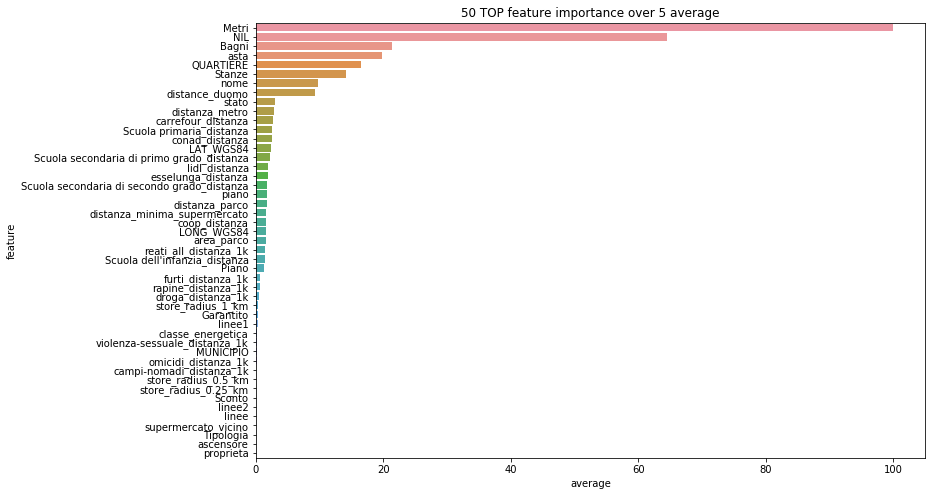

In [179]:
scaler = MinMaxScaler(feature_range=(0, 100))


feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)))

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} average'.format(fold_+1))


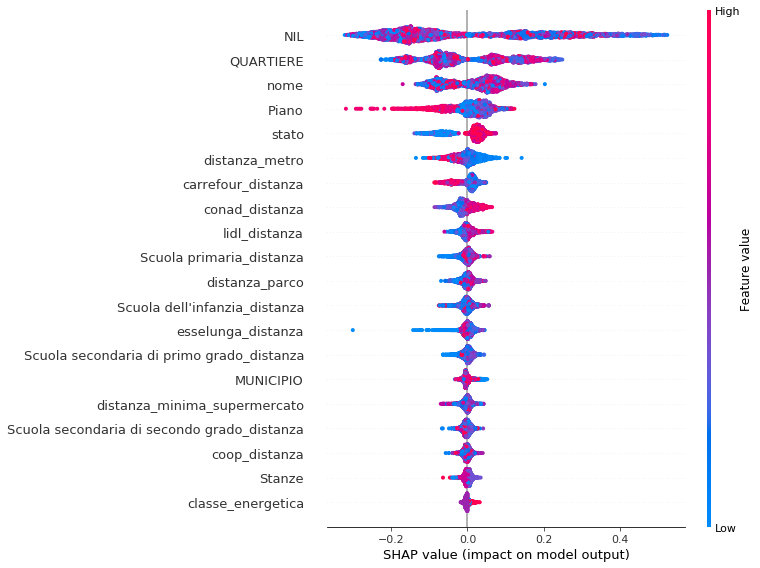

In [17]:
shap.summary_plot(shap_matrix, train)

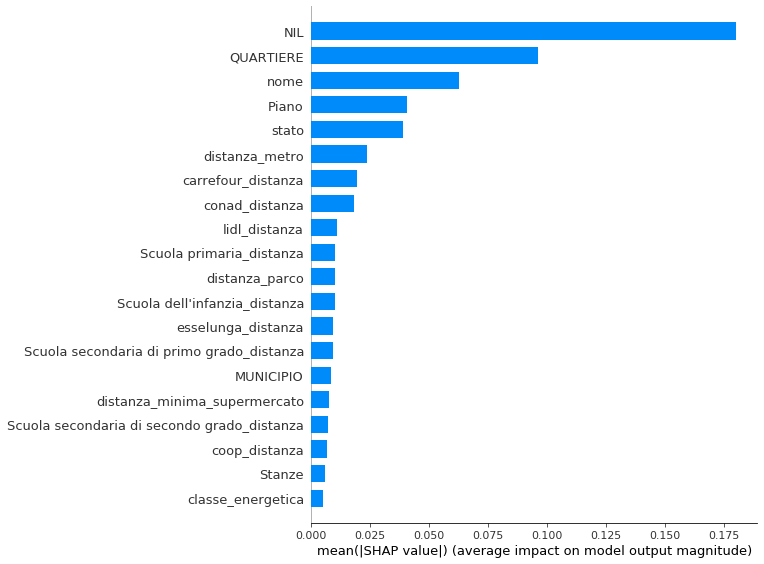

In [18]:
shap.summary_plot(shap_matrix, train, plot_type="bar")

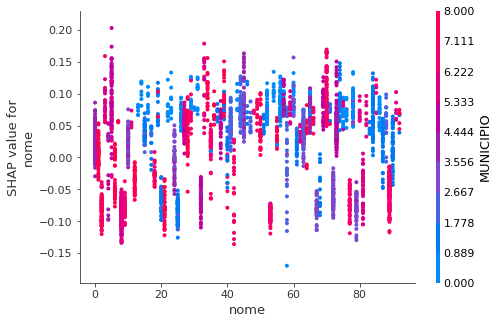

In [19]:
shap.dependence_plot("nome", shap_matrix, train)

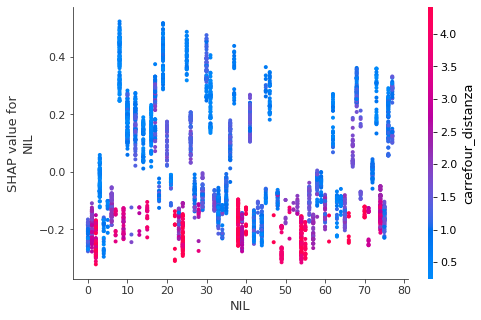

In [20]:
shap.dependence_plot("NIL", shap_matrix, train)


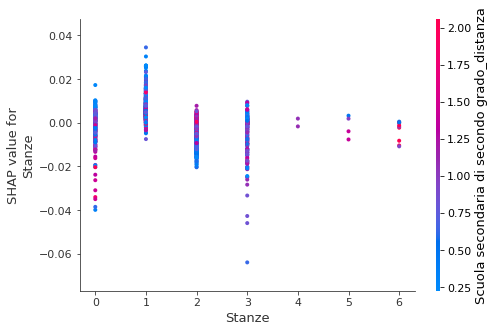

In [21]:
shap.dependence_plot("Stanze", shap_matrix, train)


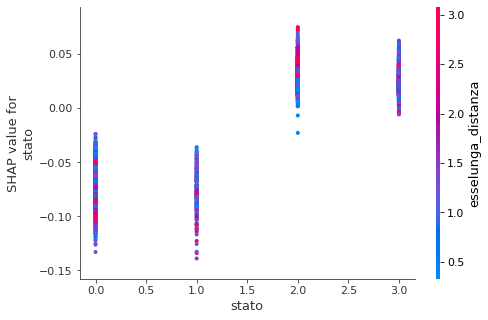

In [22]:
shap.dependence_plot("stato", shap_matrix, train)


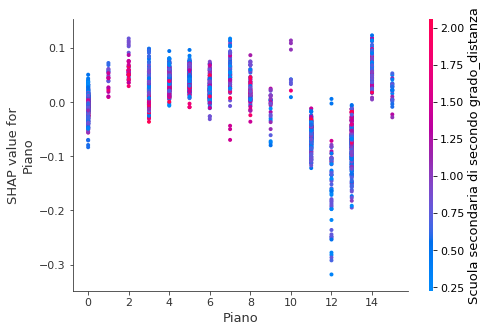

In [23]:
shap.dependence_plot("Piano", shap_matrix, train)

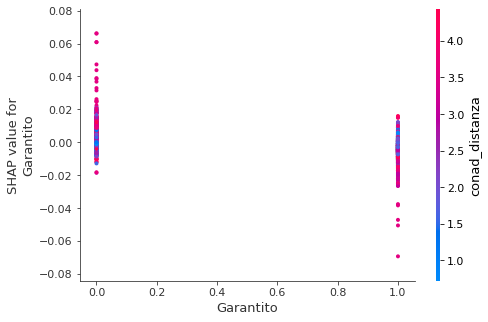

In [24]:
shap.dependence_plot("Garantito", shap_matrix, train)


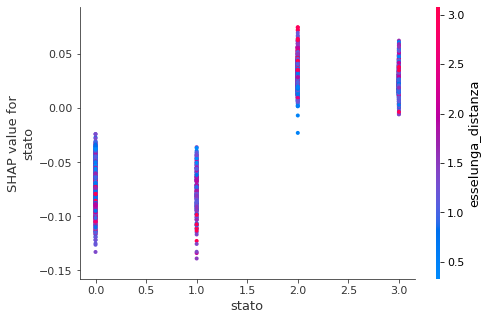

In [25]:
shap.dependence_plot("stato", shap_matrix, train)
